# Results of model-informed precision dosing using PKPD modelling

In [1]:
import os
import string

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import myokit
import numpy as np
import pandas as pd
import pints
import seaborn as sns
import xarray as xr
sns.set_theme()

from model import (
    define_hamberg_model,
    define_steady_state_hamberg_model,
    HambergEliminationRateCovariateModel,
    HambergEC50CovariateModel
)

## Calibration to trial phase I data

Import data

In [2]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

Reshape data and compute residuals

In [3]:
# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates = np.empty(shape=(len(ids), 2))
covariates[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
covariates[:, 1] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        indiv_fits[idx, idd] = mechanistic_model.simulate(
            indiv_params, times)[0]

cov_model = HambergEliminationRateCovariateModel()
pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(pop_parameters):
    for idd, covs in enumerate(covariates):
        log_ke, _ = cov_model.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :])[0, :, 0]
        pop_fits[idx, idd] = mechanistic_model.simulate(
            parameters=np.exp([log_ke, samples[5]]), times=times)[0]

Visualise results

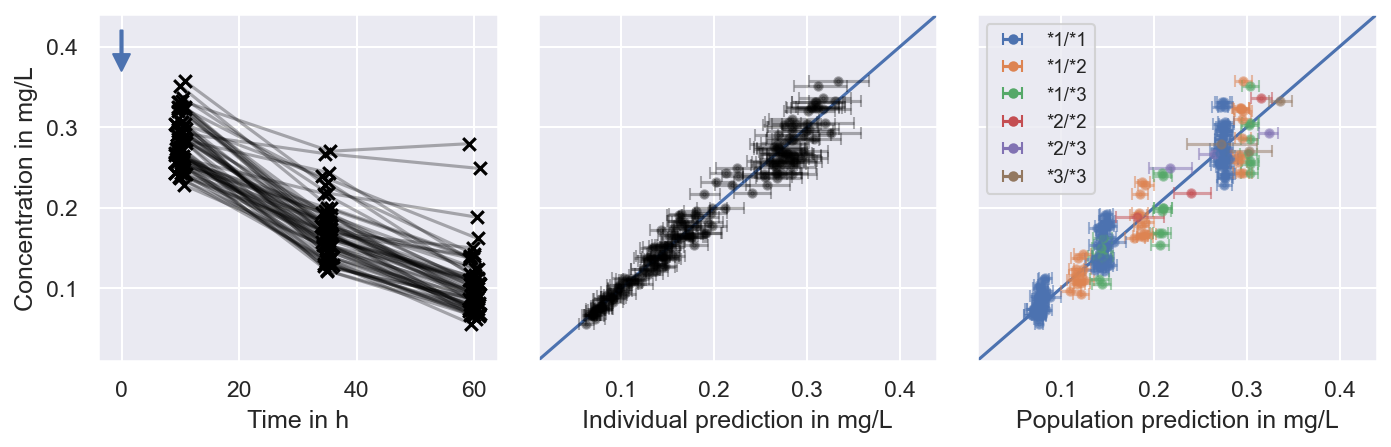

In [5]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.37), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=8, headlength=8, color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits, axis=0)
fifth = medians - np.percentile(indiv_fits, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits, axis=0)
fifth = medians - np.percentile(pop_fits, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, concs[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates[idf, 0])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates[idf, 0])])

# Add legend to population residuals
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_ylabel('')
axes[0].set_xlim([-4, 64])
axes[1].set_ylim([0.01, 0.44])
axes[1].set_xlim([0.01, 0.44])
axes[2].set_ylim([0.01, 0.44])
axes[2].set_xlim([0.01, 0.44])

plt.savefig('1_trial_phase_1.pdf', bbox_inches='tight')
plt.savefig('1_trial_phase_1.tif', bbox_inches='tight')

plt.show()

Covariate summary

In [6]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 0] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 0] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 0] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 0] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 0] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 0] == 5) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 1]),
        np.percentile(covariates[:, 1], q=5),
        np.percentile(covariates[:, 1], q=95)))

Fraction with *1/*1:  0.6166666666666667
Fraction with *1/*2:  0.2
Fraction with *1/*3:  0.13333333333333333
Fraction with *2/*2:  0.016666666666666666
Fraction with *2/*3:  0.016666666666666666
Fraction with *3/*3:  0.016666666666666666
Age: 69 (58 - 79)


Visualise posterior distribution

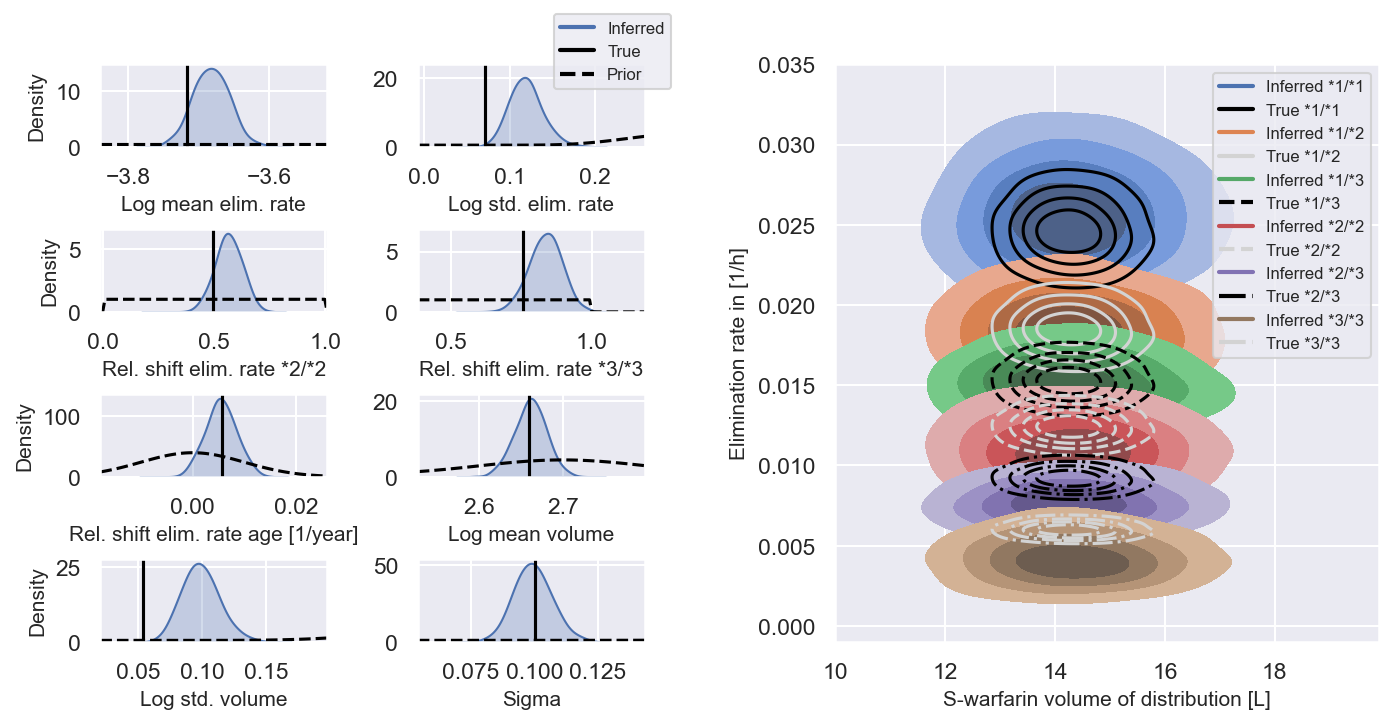

In [7]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.35, width_ratios=[1, 1])

# Create axes for marginal posteriors
axes = []
inner = gridspec.GridSpecFromSubplotSpec(
    4, 2, subplot_spec=outer[0], hspace=1, wspace=0.4)
axes.append(plt.Subplot(fig, inner[0]))
axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, inner[4]))
axes.append(plt.Subplot(fig, inner[5]))
axes.append(plt.Subplot(fig, inner[6]))
axes.append(plt.Subplot(fig, inner[7]))

# Create axis for IIV parameters
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3, 0.1),       # Mean log clearance
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log clearance
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *2
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0, 0.01),       # Rel. shift clearance Age
    pints.GaussianLogPrior(2.7, 0.1),      # Mean log volume
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)       # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp in [0, 1, 5, 6]:
        evals = np.array(evals) + 0.5
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Plot data-generating distribution as reference to parameter space
true_parameters = [-3.716, 0.071, 0.495, 0.757, 0.00571, 3.353, 0.054, 0.1]
for idx, ax in enumerate(axes[:-1]):
    p = true_parameters[idx]
    if idx == 5:
        p -= np.log(2)
    ax.axvline(x=p, color='black', linestyle='solid')

# Plot inferred population distribution
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(),
    chi.PooledModel()])
parameters = pop_parameters[np.random.choice(
    np.arange(len(pop_parameters)), size=n_samples, replace=True)]

# Define covariates
typical_age = 68
np.random.seed(12)
covariates = np.zeros(shape=(n_samples, 2))
covariates[:, 1] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_samples)

# Sample subpopulations
styles = ['solid', 'solid', 'dashed', 'dashed', 'dashdot', 'dashdot']
colors = ['black', 'lightgrey', 'black', 'lightgrey', 'black', 'lightgrey']
for idc, cyp in enumerate([0, 1, 2, 3, 4, 5]):
    covariates[:, 0] = cyp
    samples = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(parameters):
        cov = covariates[ids:ids+1]
        samples[ids, :] = population_model.sample(
            params, seed=seed, covariates=cov)[0]
    sns.kdeplot(
        x=samples[:, 1], y=samples[:, 0], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[-1])

    # Plot data-generating distribution as reference to parameter space
    samples = population_model.sample(
        true_parameters, n_samples, seed=1, covariates=covariates)
    sns.kdeplot(
        x=samples[:, 1] / 2, y=samples[:, 0], fill=False, bw_adjust=1.5,
        color=colors[idc], levels=[0.2, 0.4, 0.6, 0.8, 1],
        ax=axes[-1], linestyles=styles[idc])

# Add legends
axes[1].set_ylim([0, 24])
axes[1].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='True', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Prior', linewidth=2)
axes[1].legend(loc=[0.6, 0.7], fontsize=int(0.8 * fontsize))

axes[-1].set_ylim([-0.001, 0.035])
axes[-1].set_xlim([10, 19.9])
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=sns.color_palette()[idl],
        label='Inferred %s' % label, linewidth=2)
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=colors[idl], linestyle=styles[idl],
        label='True %s' % label, linewidth=2)
axes[-1].legend(fontsize=int(0.8 * fontsize))


# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('Density', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('Density', fontsize=fontsize)
axes[5].set_xlabel('Log mean volume', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel('Log std. volume', fontsize=fontsize)
axes[6].set_ylabel('Density', fontsize=fontsize)
axes[7].set_xlabel('Sigma', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)
axes[8].set_ylabel('Elimination rate in [1/h]', fontsize=fontsize)
axes[8].set_xlabel('S-warfarin volume of distribution [L]', fontsize=fontsize)

plt.savefig('2_trial_phase_1_parameter_space.pdf', bbox_inches='tight')
plt.savefig('2_trial_phase_1_parameter_space.tif', bbox_inches='tight')

plt.show()

Find prior distributions for inference from trial phase II

In [66]:
print(np.mean(pop_parameters[:, 7]))
print(np.std(pop_parameters[:, 7], ddof=1))

0.09931340775108191
0.007338743675987354


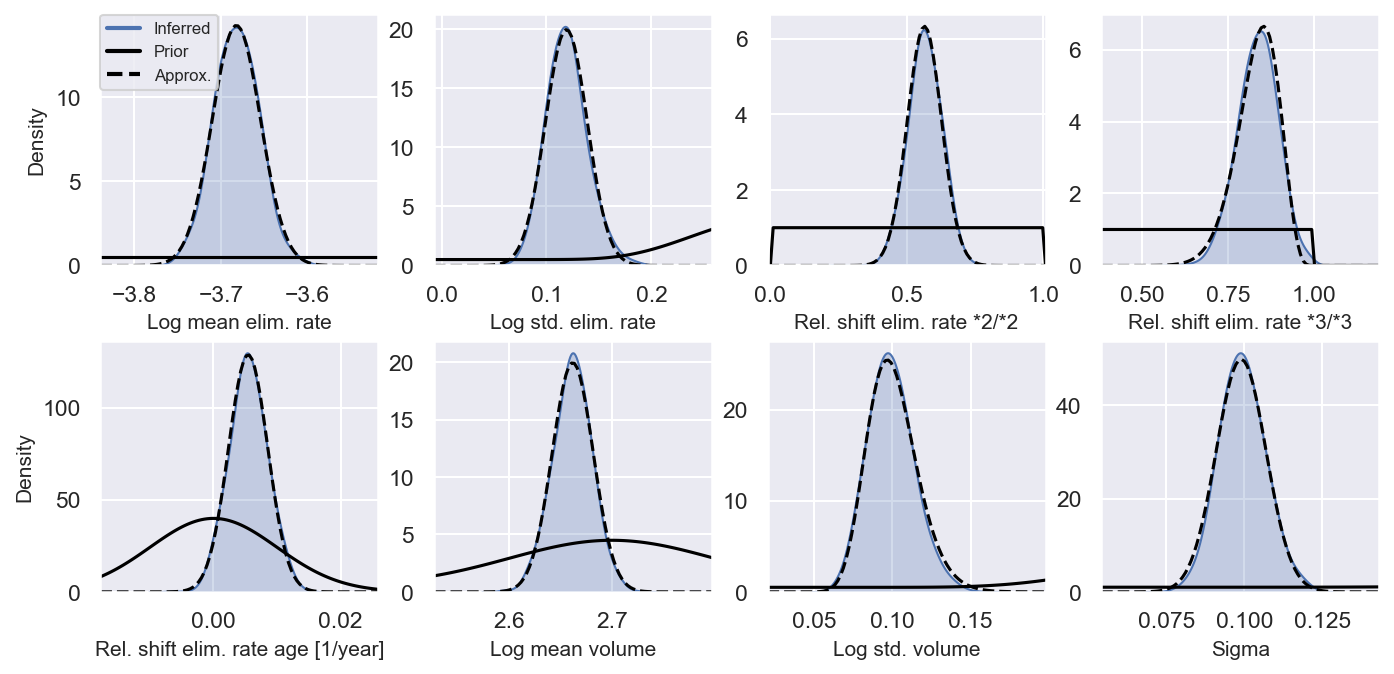

In [69]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(2, 4, wspace=0.2, hspace=0.3)

# Create axes for marginal posteriors
axes = []
axes.append(plt.Subplot(fig, outer[0]))
axes.append(plt.Subplot(fig, outer[1]))
axes.append(plt.Subplot(fig, outer[2]))
axes.append(plt.Subplot(fig, outer[3]))
axes.append(plt.Subplot(fig, outer[4]))
axes.append(plt.Subplot(fig, outer[5]))
axes.append(plt.Subplot(fig, outer[6]))
axes.append(plt.Subplot(fig, outer[7]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3, 0.1),       # Mean log clearance
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log clearance
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *2
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0, 0.01),       # Rel. shift clearance Age
    pints.GaussianLogPrior(2.7, 0.1),      # Mean log volume
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)       # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp in [0, 1, 5, 6]:
        evals = np.array(evals) + 0.5
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='solid')
    axes[idp].set_xlim([min_value, max_value])

# Plot approximate posteriors
log_priors = [
    pints.GaussianLogPrior(-3.682, 0.028),    # Mean log clearance
    pints.GaussianLogPrior(0.119, 0.02),      # Sigma log clearance
    pints.GaussianLogPrior(0.565, 0.063),     # Rel. shift clearance CYP29P *2
    pints.BetaLogPrior(30, 6),                # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00546, 0.0031),  # Rel. shift clearance Age
    pints.GaussianLogPrior(2.662, 0.02),      # Mean log volume
    pints.LogNormalLogPrior(-2.31, 0.16),     # Sigma log volume
    pints.GaussianLogPrior(0.099, 0.008)      # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Add legends
axes[0].set_ylim([0, 14.9])
axes[0].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[0].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='Prior', linewidth=2)
axes[0].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Approx.', linewidth=2)
axes[0].legend(loc=[0, 0.7], fontsize=int(0.8 * fontsize))

# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('Density', fontsize=fontsize)
axes[5].set_xlabel('Log mean volume', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel('Log std. volume', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel('Sigma', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)

plt.savefig('2_trial_phase_1_approximate_posteriors.pdf', bbox_inches='tight')
plt.savefig('2_trial_phase_1_approximate_posteriors.tif', bbox_inches='tight')

plt.show()

## Calibration to trial phase II data

Import data

In [28]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_II.csv')

# Define model
mechanistic_model, _ = define_hamberg_model()
mechanistic_model.set_outputs(['myokit.inr'])
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_II.nc')

Reshape data

In [29]:
# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique() // 24
inrs = np.empty(shape=(len(ids), len(times)))
doses = np.empty(shape=(len(ids), int(times[-1])))
covariates = np.empty(shape=(len(ids), 3))
for idx, _id in enumerate(ids):
    inrs[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values
    covariates[idx, 0] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates[idx, 1] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates[idx, 2] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# # Get model fits
# pop_parameters = np.vstack([
#     posterior['Log mean myokit.elimination_rate'].values.flatten(),
#     posterior['Log std. myokit.elimination_rate'].values.flatten(),
#     posterior['Rel. elimination rate shift *2*2'].values.flatten(),
#     posterior['Rel. elimination rate shift *3*3'].values.flatten(),
#     posterior['Rel. elimination rate shift with age'].values.flatten(),
#     posterior[
#         'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
#     posterior[
#         'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
#     posterior['Rel. EC50 shift AA'].values.flatten(),
#     posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
#     posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
#     posterior['Log mean myokit.volume'].values.flatten(),
#     posterior['Log std. myokit.volume'].values.flatten()]).T
# indiv_parameters = np.vstack([
#     posterior['myokit.elimination_rate'].values,
#     posterior['myokit.half_maximal_effect_concentration'].values,
#     posterior['myokit.volume'].values]).T

# n_samples = len(pop_parameters)
# parameters = np.empty(shape=(n_samples, len(ids), 5))
# parameters[:, :, 2] = pop_parameters[:, 8][:, np.newaxis]
# parameters[:, :, 3] = pop_parameters[:, 9][:, np.newaxis]
# pop_p = pop_parameters[:, [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]]
# for idx in range(n_samples):
#     p = population_model.compute_individual_parameters(
#         parameters=pop_p[idx],
#         eta=indiv_parameters[:, idx],
#         covariates=covariates)
#     parameters[idx, :, 0] = p[:, 0]
#     parameters[idx, :, 1] = p[:, 1]
#     parameters[idx, :, 4] = p[:, 2]

# duration = 0.01
# # indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
# indiv_fits = np.empty(shape=(100, len(ids), len(times)))
# for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
#     # Set dosing regimen
#     regimen = myokit.Protocol()
#     for day, dose in enumerate(doses[idd]):
#         dose_rate = dose / duration
#         regimen.add(myokit.ProtocolEvent(
#             level=dose_rate, start=day*24, duration=duration))
#     mechanistic_model.set_dosing_regimen(regimen)
#     for idx, sample in enumerate(indiv_params[:100]):
#         indiv_fits[idx, idd] = mechanistic_model.simulate(
#             sample, times*24)[0]

# cov_model1 = HambergEliminationRateCovariateModel()
# cov_model2 = HambergEC50CovariateModel()
# # pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
# pop_fits = np.empty(shape=(100, len(ids), len(times)))
# for idd, covs in enumerate(covariates):
#     # Set dosing regimen
#     regimen = myokit.Protocol()
#     for day, dose in enumerate(doses[idd]):
#         dose_rate = dose / duration
#         regimen.add(myokit.ProtocolEvent(
#             level=dose_rate, start=day*24, duration=duration))
#     mechanistic_model.set_dosing_regimen(regimen)
#     for idx, samples in enumerate(pop_parameters[:100]):
#         log_ke, _ = cov_model1.compute_population_parameters(
#             parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
#             covariates=covs[np.newaxis, :2])[0, :, 0]
#         log_ec50, _ = cov_model2.compute_population_parameters(
#             parameters=samples[7:8],
#             pop_parameters=samples[5:7][:, np.newaxis],
#             covariates=covs[np.newaxis, 2:])[0, :, 0]
#         pop_fits[idx, idd] = mechanistic_model.simulate(
#             parameters=[
#                 np.exp(log_ke),
#                 np.exp(log_ec50),
#                 samples[8],
#                 samples[9],
#                 np.exp(samples[10])
#                 ],
#             times=times*24)[0]

Visualise results

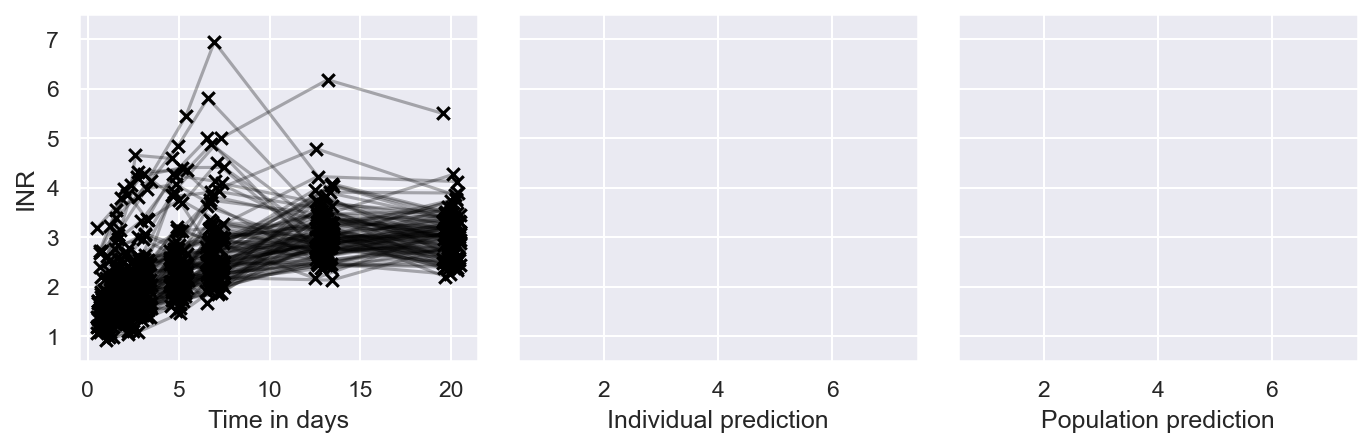

In [32]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in inrs:
    jitter = np.random.uniform(-0.5, 0.5, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='x', color='black',
        alpha=0.3)
    axes[0].scatter(
        times + jitter, c, marker='x', color='black')

# # Visualise residuals
# axes[1].plot(
#     [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
# medians = np.median(indiv_fits, axis=0)
# fifth = medians - np.percentile(indiv_fits, axis=0, q=5)
# ninetyfifth = np.percentile(indiv_fits, axis=0, q=95) - medians
# for idf, f in enumerate(medians):
#     axes[1].errorbar(
#         f, inrs[idf], marker='o', color='black', alpha=0.3, ls='none',
#         xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
#         capsize=3, markersize=4)
#     axes[1].scatter(
#         f, inrs[idf], marker='o', color='black', alpha=0.3, s=4)

# axes[2].plot(
#     [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
# medians = np.median(pop_fits, axis=0)
# fifth = medians - np.percentile(pop_fits, axis=0, q=5)
# ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
# for idf, f in enumerate(medians):
#     axes[2].errorbar(
#         f, inrs[idf], marker='o', alpha=0.5, ls='none',
#         color=sns.color_palette()[int(covariates[idf, 2])],
#         xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
#         capsize=3, markersize=4)
#     axes[2].scatter(
#         f, inrs[idf], marker='o', alpha=0.5, s=4,
#         color=sns.color_palette()[int(covariates[idf, 2])])

# # Add legend to population residuals
# labels = ['GG', 'GA', 'AA']
# for idl, label in enumerate(labels):
#     axes[2].errorbar(
#             [0, 0], [10, 11], marker='o', ls='none',
#             color=sns.color_palette()[idl], label=label,
#             xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
# axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in days')
axes[0].set_ylabel('INR')
axes[1].set_xlabel('Individual prediction')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction')
axes[2].set_ylabel('')
axes[0].set_ylim([0.5, 7.5])
axes[1].set_xlim([0.5, 7.5])
axes[2].set_xlim([0.5, 7.5])

# plt.savefig('3_trial_phase_2.pdf', bbox_inches='tight')
# plt.savefig('3_trial_phase_2.tif', bbox_inches='tight')

plt.show()

Summarise demographics

In [420]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 0] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 0] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 0] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 0] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 0] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 0] == 5) / len(covariates))
print('Fraction with GG: ', np.sum(covariates[:, 2] == 0) / len(covariates))
print('Fraction with GA: ', np.sum(covariates[:, 2] == 1) / len(covariates))
print('Fraction with AA: ', np.sum(covariates[:, 2] == 2) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 1]),
        np.percentile(covariates[:, 1], q=5),
        np.percentile(covariates[:, 1], q=95)))

Fraction with *1/*1:  0.63
Fraction with *1/*2:  0.19
Fraction with *1/*3:  0.13
Fraction with *2/*2:  0.02
Fraction with *2/*3:  0.02
Fraction with *3/*3:  0.01
Fraction with GG:  0.36
Fraction with GA:  0.49
Fraction with AA:  0.15
Age: 65 (56 - 76)


Visualise posterior distribution

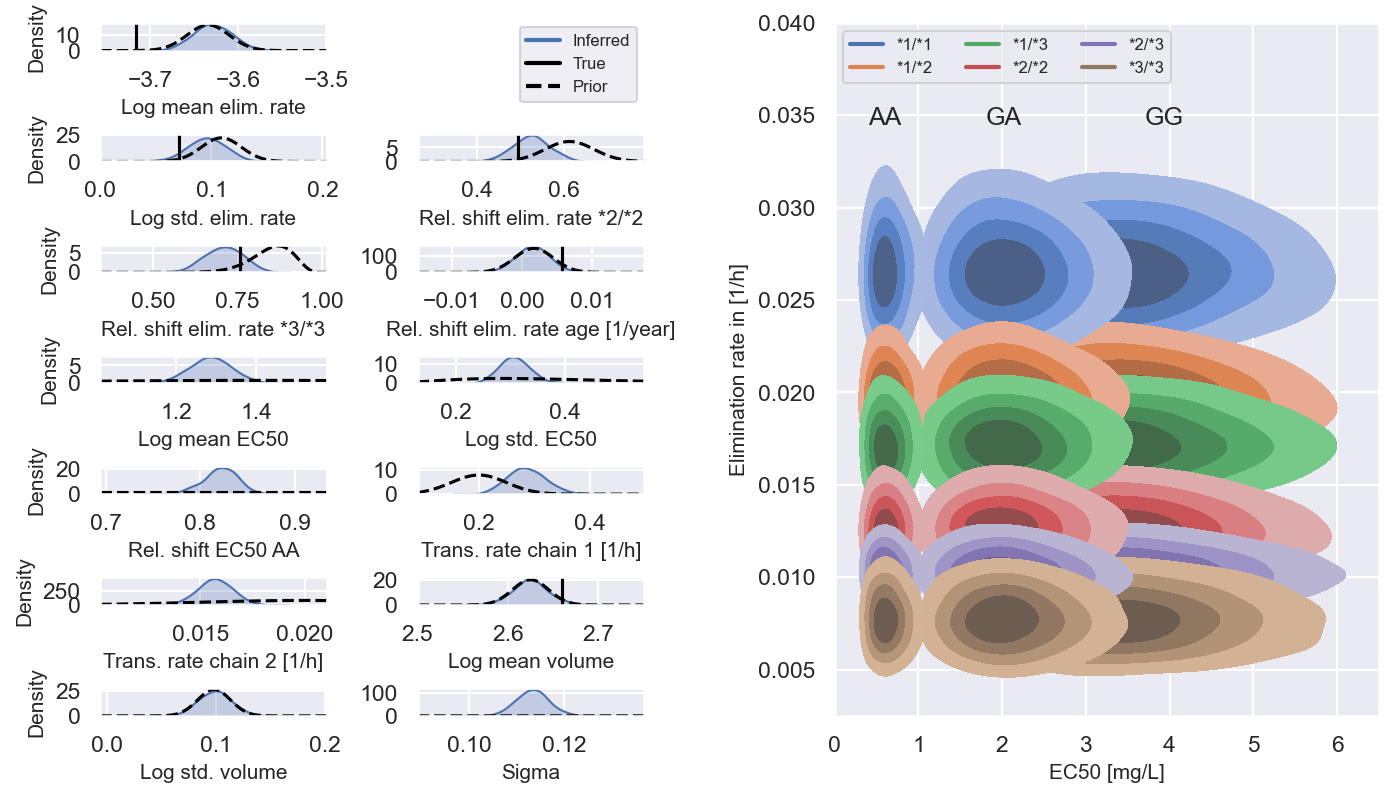

In [421]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.35, width_ratios=[1, 1])

# Create axes for marginal posteriors
axes = []
inner = gridspec.GridSpecFromSubplotSpec(
    7, 2, subplot_spec=outer[0], hspace=3, wspace=0.4)
axes.append(plt.Subplot(fig, inner[0]))
# axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, inner[4]))
axes.append(plt.Subplot(fig, inner[5]))
axes.append(plt.Subplot(fig, inner[6]))
axes.append(plt.Subplot(fig, inner[7]))
axes.append(plt.Subplot(fig, inner[8]))
axes.append(plt.Subplot(fig, inner[9]))
axes.append(plt.Subplot(fig, inner[10]))
axes.append(plt.Subplot(fig, inner[11]))
axes.append(plt.Subplot(fig, inner[12]))
axes.append(plt.Subplot(fig, inner[13]))

# Create axis for IIV parameters
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 10000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 8], fill=True, ax=axes[8], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 9], fill=True, ax=axes[9], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 10], fill=True, ax=axes[10], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 11], fill=True, ax=axes[11], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 12], fill=True, ax=axes[12], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3.634, 0.024),     # Mean log clearance
    pints.GaussianLogPrior(0.109, 0.018),      # Sigma log clearance
    pints.GaussianLogPrior(0.612, 0.056),      # Rel. shift clearance CYP29P *2
    pints.BetaLogPrior(28, 5),                 # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00173, 0.00274),  # Rel. shift clearance Age
    pints.GaussianLogPrior(1.41, 0.5),         # Mean log EC50
    pints.LogNormalLogPrior(-1, 0.5),           # Sigma log EC50
    pints.UniformLogPrior(0, 1),               # Rel. shift EC50 VKORC1 A
    pints.GaussianLogPrior(0.2, 0.05),         # Transition rate chain 1
    pints.GaussianLogPrior(0.02, 0.005),       # Transition rate chain 2
    pints.GaussianLogPrior(2.625, 0.020),      # Mean log volume
    pints.GaussianLogPrior(0.098, 0.015),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)           # Sigma log INR
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Plot data-generating distribution as reference to parameter space
true_parameters = [
    -3.716, 0.071, 0.495, 0.757, 0.00571, np.nan, np.nan, np.nan, np.nan,
    np.nan, 3.353 - np.log(2), np.nan, np.nan]
for idp, p in enumerate(true_parameters):
    if np.isnan(p):
        continue
    axes[idp].axvline(x=p, color='black', linestyle='solid')

# Plot inferred population distribution
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEC50CovariateModel()),
    chi.PooledModel(),
    chi.PooledModel(),
    chi.LogNormalModel(),
    chi.PooledModel()])
parameters = pop_parameters[np.random.choice(
    np.arange(len(pop_parameters)), size=n_samples, replace=True)]

# Define covariates
typical_age = 68
np.random.seed(12)
covariates = np.zeros(shape=(n_samples, 3))
covariates[:, 1] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_samples)

# Sample subpopulations
for vkorc in [0, 1, 2]:
    covariates[:, 2] = vkorc
    for idc, cyp in enumerate([0, 1, 2, 3, 4, 5]):
        covariates[:, 0] = cyp
        samples = np.empty(shape=(n_samples, 6))
        for ids, params in enumerate(parameters):
            cov = covariates[ids:ids+1]
            samples[ids, :] = population_model.sample(
                params, seed=seed, covariates=cov)[0]
        sns.kdeplot(
            x=samples[:, 1], y=samples[:, 0], fill=True, bw_adjust=1.5,
            levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[-1],
            color=sns.color_palette()[idc])

# Add legends
axes[1].set_ylim([0, 26])
axes[1].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='True', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Prior', linewidth=2)
axes[1].legend(loc=[1.85, 2.15], fontsize=int(0.8 * fontsize))

axes[-1].set_ylim([0.0025, 0.04])
axes[-1].set_xlim([0, 6.5])
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=sns.color_palette()[idl],
        label='%s' % label, linewidth=2)
axes[-1].legend(fontsize=int(0.8 * fontsize), ncol=3, loc='upper left')
axes[-1].annotate(text='AA', xy=(0.4, 0.0345))
axes[-1].annotate(text='GA', xy=(1.8, 0.0345))
axes[-1].annotate(text='GG', xy=(3.7, 0.0345))


# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('Density', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('Density', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('', fontsize=fontsize)
axes[5].set_xlabel('Log mean EC50', fontsize=fontsize)
axes[5].set_ylabel('Density', fontsize=fontsize)
axes[6].set_xlabel('Log std. EC50', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel('Rel. shift EC50 AA', fontsize=fontsize)
axes[7].set_ylabel('Density', fontsize=fontsize)
axes[8].set_xlabel('Trans. rate chain 1 [1/h]', fontsize=fontsize)
axes[8].set_ylabel('', fontsize=fontsize)
axes[9].set_xlabel('Trans. rate chain 2 [1/h]', fontsize=fontsize)
axes[9].set_ylabel('Density', fontsize=fontsize)
axes[10].set_xlabel('Log mean volume', fontsize=fontsize)
axes[10].set_ylabel('', fontsize=fontsize)
axes[11].set_xlabel('Log std. volume', fontsize=fontsize)
axes[11].set_ylabel('Density', fontsize=fontsize)
axes[12].set_xlabel('Sigma', fontsize=fontsize)
axes[12].set_ylabel('', fontsize=fontsize)
axes[13].set_ylabel('Elimination rate in [1/h]', fontsize=fontsize)
axes[13].set_xlabel('EC50 [mg/L]', fontsize=fontsize)

plt.savefig('4_trial_phase_2_parameter_space.pdf', bbox_inches='tight')
plt.savefig('4_trial_phase_2_parameter_space.tif', bbox_inches='tight')

plt.show()

## Calibrate to trial phase III

Import data

In [33]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_III.csv')

# Define model
mechanistic_model, _ = define_steady_state_hamberg_model()
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_III.nc')

Reshape data

In [35]:
# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
inrs = np.empty(shape=len(ids))
doses = np.empty(shape=(len(ids)))
covariates = np.empty(shape=(len(ids), 3))
for idx, _id in enumerate(ids):
    inrs[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values
    covariates[idx, 0] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates[idx, 1] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates[idx, 2] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# # Get model fits
# pop_parameters = np.vstack([
#     posterior['Log mean myokit.elimination_rate'].values.flatten(),
#     posterior['Log std. myokit.elimination_rate'].values.flatten(),
#     posterior['Rel. elimination rate shift *2*2'].values.flatten(),
#     posterior['Rel. elimination rate shift *3*3'].values.flatten(),
#     posterior['Rel. elimination rate shift with age'].values.flatten(),
#     posterior[
#         'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
#     posterior[
#         'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
#     posterior['Rel. EC50 shift AA'].values.flatten(),
#     posterior['Log mean myokit.volume'].values.flatten(),
#     posterior['Log std. myokit.volume'].values.flatten()]).T
# indiv_parameters = np.vstack([
#     posterior['myokit.elimination_rate'].values,
#     posterior['myokit.half_maximal_effect_concentration'].values,
#     posterior['myokit.volume'].values]).T

# n_samples = len(pop_parameters)
# parameters = np.empty(shape=(n_samples, len(ids), 3))
# for idx in range(n_samples):
#     parameters[idx] = population_model.compute_individual_parameters(
#         parameters=pop_parameters[idx],
#         eta=indiv_parameters[:, idx],
#         covariates=covariates)

# duration = 0.01
# times = [100]  # Does not influence the simulation (Steady state)
# indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
# for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
#     # Set dosing regimen
#     regimen = myokit.Protocol()
#     for day, dose in enumerate(doses[idd]):
#         dose_rate = dose / duration
#         regimen.add(myokit.ProtocolEvent(
#             level=dose_rate, start=day*24, duration=duration))
#     mechanistic_model.set_dosing_regimen(regimen)
#     for idx, sample in enumerate(indiv_params):
#         indiv_fits[idx, idd] = mechanistic_model.simulate(
#             sample, times)[0]

# cov_model1 = HambergEliminationRateCovariateModel()
# cov_model2 = HambergEC50CovariateModel()
# pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
# for idd, covs in enumerate(covariates):
#     # Set dosing regimen
#     regimen = myokit.Protocol()
#     for day, dose in enumerate(doses[idd]):
#         dose_rate = dose / duration
#         regimen.add(myokit.ProtocolEvent(
#             level=dose_rate, start=day*24, duration=duration))
#     mechanistic_model.set_dosing_regimen(regimen)
#     for idx, samples in enumerate(pop_parameters):
#         log_ke, _ = cov_model1.compute_population_parameters(
#             parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
#             covariates=covs[np.newaxis, :2])[0, :, 0]
#         log_ec50, _ = cov_model2.compute_population_parameters(
#             parameters=samples[7:8],
#             pop_parameters=samples[5:7][:, np.newaxis],
#             covariates=covs[np.newaxis, 2:])[0, :, 0]
#         pop_fits[idx, idd] = mechanistic_model.simulate(
#             parameters=[
#                 np.exp(log_ke),
#                 np.exp(log_ec50),
#                 np.exp(samples[8])
#                 ],
#             times=times)[0]

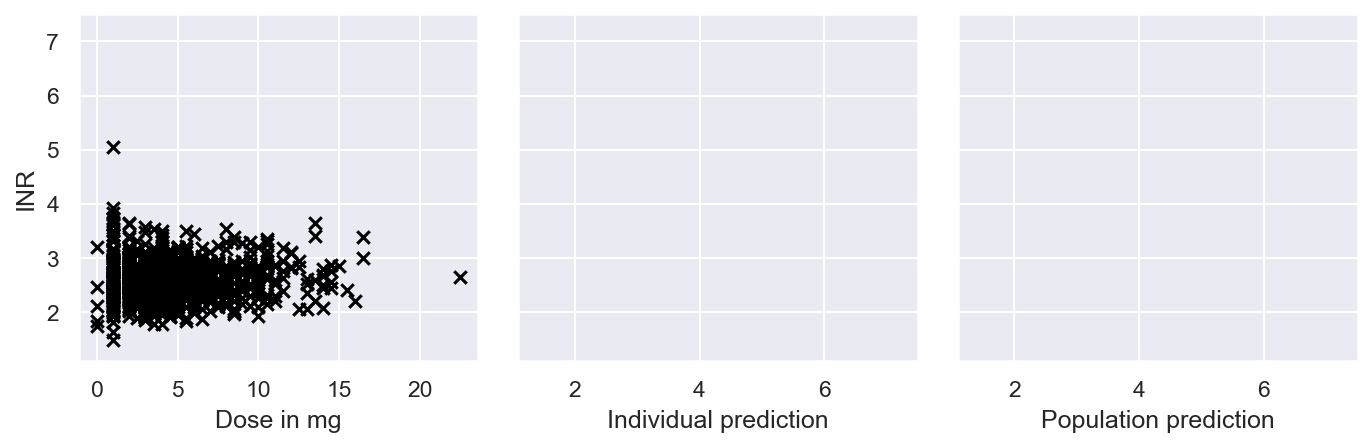

In [40]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
axes[0].scatter(
    doses, inrs, marker='x', color='black')

# # Visualise residuals
# axes[1].plot(
#     [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
# medians = np.median(indiv_fits, axis=0)
# fifth = medians - np.percentile(indiv_fits, axis=0, q=5)
# ninetyfifth = np.percentile(indiv_fits, axis=0, q=95) - medians
# for idf, f in enumerate(medians):
#     axes[1].errorbar(
#         f, inrs[idf], marker='o', color='black', alpha=0.3, ls='none',
#         xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
#         capsize=3, markersize=4)
#     axes[1].scatter(
#         f, inrs[idf], marker='o', color='black', alpha=0.3, s=4)

# axes[2].plot(
#     [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
# medians = np.median(pop_fits, axis=0)
# fifth = medians - np.percentile(pop_fits, axis=0, q=5)
# ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
# for idf, f in enumerate(medians):
#     axes[2].errorbar(
#         f, inrs[idf], marker='o', alpha=0.5, ls='none',
#         color=sns.color_palette()[int(covariates[idf, 2])],
#         xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
#         capsize=3, markersize=4)
#     axes[2].scatter(
#         f, inrs[idf], marker='o', alpha=0.5, s=4,
#         color=sns.color_palette()[int(covariates[idf, 2])])

# # Add legend to population residuals
# labels = ['GG', 'GA', 'AA']
# for idl, label in enumerate(labels):
#     axes[2].errorbar(
#             [0, 0], [10, 11], marker='o', ls='none',
#             color=sns.color_palette()[idl], label=label,
#             xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
# axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Dose in mg')
axes[0].set_ylabel('INR')
axes[1].set_xlabel('Individual prediction')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction')
axes[2].set_ylabel('')
axes[0].set_ylim([1.1, 7.5])
axes[1].set_xlim([1.1, 7.5])
axes[2].set_xlim([1.1, 7.5])

# plt.savefig('5_trial_phase_3.pdf', bbox_inches='tight')
# plt.savefig('5_trial_phase_3.tif', bbox_inches='tight')

plt.show()

Summarise demographics

In [30]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 0] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 0] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 0] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 0] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 0] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 0] == 5) / len(covariates))
print('Fraction with GG: ', np.sum(covariates[:, 2] == 0) / len(covariates))
print('Fraction with GA: ', np.sum(covariates[:, 2] == 1) / len(covariates))
print('Fraction with AA: ', np.sum(covariates[:, 2] == 2) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 1]),
        np.percentile(covariates[:, 1], q=5),
        np.percentile(covariates[:, 1], q=95)))

Fraction with *1/*1:  0.661
Fraction with *1/*2:  0.184
Fraction with *1/*3:  0.123
Fraction with *2/*2:  0.014
Fraction with *2/*3:  0.012
Fraction with *3/*3:  0.006
Fraction with GG:  0.365
Fraction with GA:  0.485
Fraction with AA:  0.15
Age: 50 (40 - 64)


Visualise posteriors

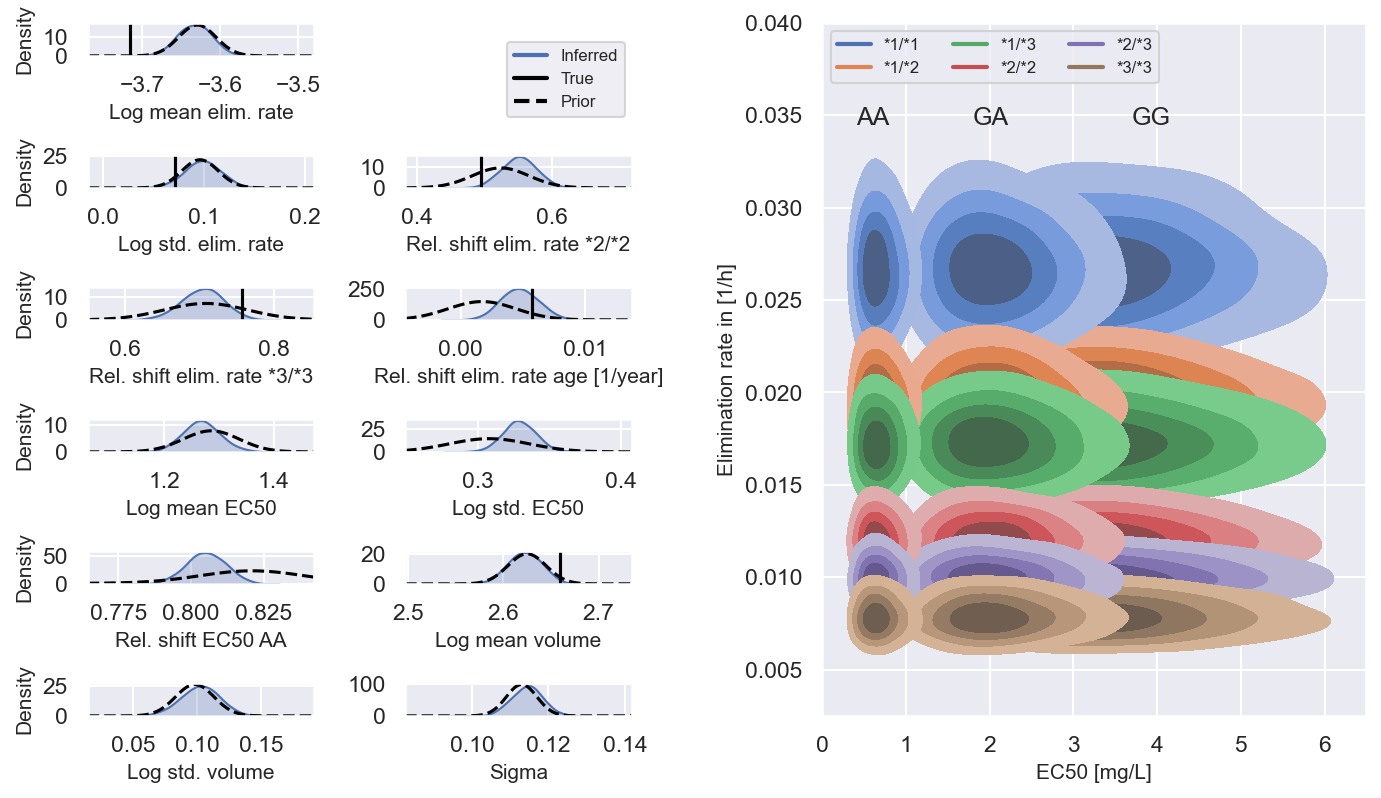

In [31]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1200 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.35, width_ratios=[1, 1])

# Create axes for marginal posteriors
axes = []
inner = gridspec.GridSpecFromSubplotSpec(
    6, 2, subplot_spec=outer[0], hspace=3, wspace=0.4)
axes.append(plt.Subplot(fig, inner[0]))
# axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, inner[4]))
axes.append(plt.Subplot(fig, inner[5]))
axes.append(plt.Subplot(fig, inner[6]))
axes.append(plt.Subplot(fig, inner[7]))
axes.append(plt.Subplot(fig, inner[8]))
axes.append(plt.Subplot(fig, inner[9]))
axes.append(plt.Subplot(fig, inner[10]))
axes.append(plt.Subplot(fig, inner[11]))

# Create axis for IIV parameters
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 10000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 8], fill=True, ax=axes[8], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 9], fill=True, ax=axes[9], bw_adjust=1.5)
sns.kdeplot(
    x=pop_parameters[:, 10], fill=True, ax=axes[10], bw_adjust=1.5)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3.629, 0.024),     # Mean log clearance
    pints.GaussianLogPrior(0.096, 0.018),      # Sigma log clearance
    pints.GaussianLogPrior(0.524, 0.042),      # Rel. shift clearance CYP29P *2
    pints.GaussianLogPrior(0.709, 0.056),      # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0.00173, 0.00274),  # Rel. shift clearance Age
    pints.GaussianLogPrior(1.286, 0.051),      # Mean log EC50
    pints.GaussianLogPrior(0.308, 0.028),      # Sigma log EC50
    pints.GaussianLogPrior(0.821, 0.018),      # Rel. shift EC50 VKORC1 A
    pints.GaussianLogPrior(2.625, 0.020),      # Mean log volume
    pints.GaussianLogPrior(0.098, 0.015),      # Sigma log volume
    pints.GaussianLogPrior(0.113, 0.004)       # Sigma log INR
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value, num=100)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Plot data-generating distribution as reference to parameter space
true_parameters = [
    -3.716, 0.071, 0.495, 0.757, 0.00571, np.nan, np.nan,
    np.nan, 3.353 - np.log(2), np.nan, np.nan]
for idp, p in enumerate(true_parameters):
    if np.isnan(p):
        continue
    axes[idp].axvline(x=p, color='black', linestyle='solid')

# Plot inferred population distribution
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(),
    chi.PooledModel()])
parameters = pop_parameters[np.random.choice(
    np.arange(len(pop_parameters)), size=n_samples, replace=True)]

# Define covariates
typical_age = 68
np.random.seed(12)
covariates = np.zeros(shape=(n_samples, 3))
covariates[:, 1] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_samples)

# Sample subpopulations
for vkorc in [0, 1, 2]:
    covariates[:, 2] = vkorc
    for idc, cyp in enumerate([0, 1, 2, 3, 4, 5]):
        covariates[:, 0] = cyp
        samples = np.empty(shape=(n_samples, 4))
        for ids, params in enumerate(parameters):
            cov = covariates[ids:ids+1]
            samples[ids, :] = population_model.sample(
                params, seed=seed, covariates=cov)[0]
        sns.kdeplot(
            x=samples[:, 1], y=samples[:, 0], fill=True, bw_adjust=1.5,
            levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[-1],
            color=sns.color_palette()[idc])

# Add legends
axes[1].set_ylim([0, 26])
axes[1].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='True', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Prior', linewidth=2)
axes[1].legend(loc=[1.85, 2.15], fontsize=int(0.8 * fontsize))

axes[-1].set_ylim([0.0025, 0.04])
axes[-1].set_xlim([0, 6.5])
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=sns.color_palette()[idl],
        label='%s' % label, linewidth=2)
axes[-1].legend(fontsize=int(0.8 * fontsize), ncol=3, loc='upper left')
axes[-1].annotate(text='AA', xy=(0.4, 0.0345))
axes[-1].annotate(text='GA', xy=(1.8, 0.0345))
axes[-1].annotate(text='GG', xy=(3.7, 0.0345))


# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('Density', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('Density', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('', fontsize=fontsize)
axes[5].set_xlabel('Log mean EC50', fontsize=fontsize)
axes[5].set_ylabel('Density', fontsize=fontsize)
axes[6].set_xlabel('Log std. EC50', fontsize=fontsize)
axes[6].set_ylabel('', fontsize=fontsize)
axes[7].set_xlabel('Rel. shift EC50 AA', fontsize=fontsize)
axes[7].set_ylabel('Density', fontsize=fontsize)
axes[8].set_xlabel('Log mean volume', fontsize=fontsize)
axes[8].set_ylabel('', fontsize=fontsize)
axes[9].set_xlabel('Log std. volume', fontsize=fontsize)
axes[9].set_ylabel('Density', fontsize=fontsize)
axes[10].set_xlabel('Sigma', fontsize=fontsize)
axes[10].set_ylabel('', fontsize=fontsize)
axes[11].set_ylabel('Elimination rate in [1/h]', fontsize=fontsize)
axes[11].set_xlabel('EC50 [mg/L]', fontsize=fontsize)

plt.savefig('6_trial_phase_3_parameter_space.pdf', bbox_inches='tight')
plt.savefig('6_trial_phase_3_parameter_space.tif', bbox_inches='tight')

plt.show()

## Combined results

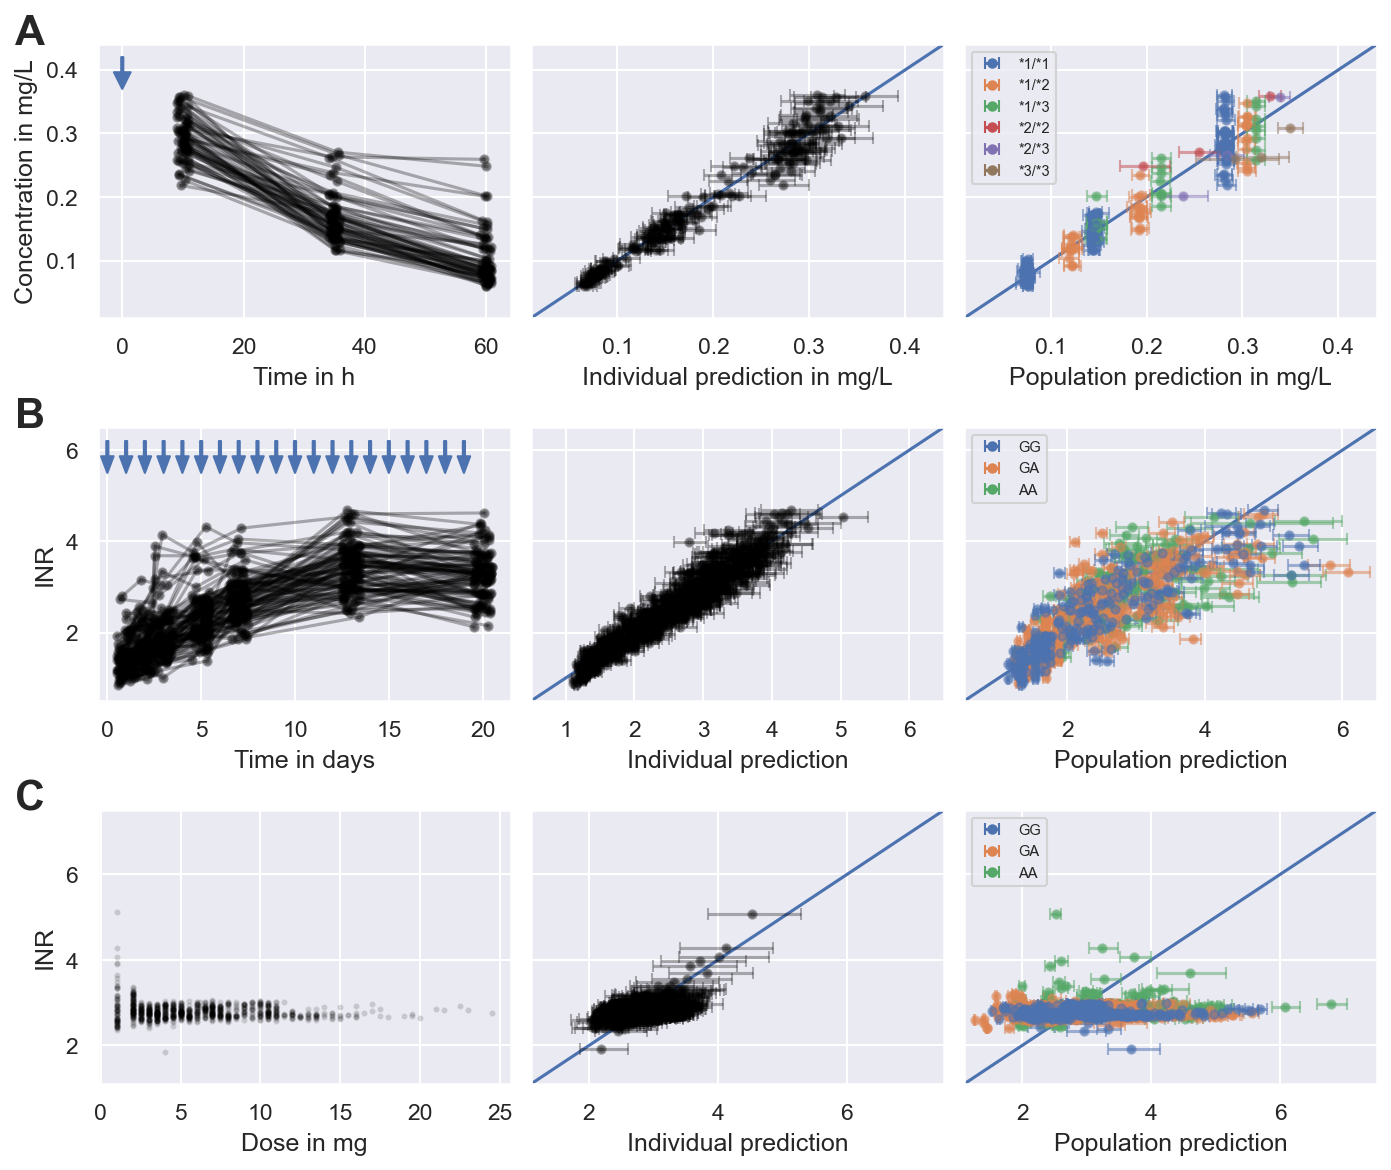

In [22]:
# Trial phase I results
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates_1 = np.empty(shape=(len(ids), 2))
covariates_1[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
covariates_1[:, 1] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_1)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
indiv_fits_1 = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        indiv_fits_1[idx, idd] = mechanistic_model.simulate(
            indiv_params, times)[0]

cov_model = HambergEliminationRateCovariateModel()
pop_fits_1 = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(pop_parameters):
    for idd, covs in enumerate(covariates_1):
        log_ke, _ = cov_model.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :])[0, :, 0]
        pop_fits_1[idx, idd] = mechanistic_model.simulate(
            parameters=np.exp([log_ke, samples[5]]), times=times)[0]
times_1 = times

# Trial phase II
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_II.csv')

# Define model
mechanistic_model, _ = define_hamberg_model()
mechanistic_model.set_outputs(['myokit.inr'])
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_II.nc')

# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique() // 24
inrs_2 = np.empty(shape=(len(ids), len(times)))
doses = np.empty(shape=(len(ids), int(times[-1])))
covariates_2 = np.empty(shape=(len(ids), 3))
for idx, _id in enumerate(ids):
    inrs_2[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values
    covariates_2[idx, 0] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates_2[idx, 1] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates_2[idx, 2] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_1'].values.flatten(),
    posterior['Pooled myokit.transition_rate_chain_2'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.half_maximal_effect_concentration'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 5))
parameters[:, :, 2] = pop_parameters[:, 8][:, np.newaxis]
parameters[:, :, 3] = pop_parameters[:, 9][:, np.newaxis]
pop_p = pop_parameters[:, [0, 1, 2, 3, 4, 5, 6, 7, 10, 11]]
for idx in range(n_samples):
    p = population_model.compute_individual_parameters(
        parameters=pop_p[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates_2)
    parameters[idx, :, 0] = p[:, 0]
    parameters[idx, :, 1] = p[:, 1]
    parameters[idx, :, 4] = p[:, 2]

duration = 0.01
# indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
indiv_fits_2 = np.empty(shape=(100, len(ids), len(times)))
for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, sample in enumerate(indiv_params[:100]):
        indiv_fits_2[idx, idd] = mechanistic_model.simulate(
            sample, times*24)[0]

cov_model1 = HambergEliminationRateCovariateModel()
cov_model2 = HambergEC50CovariateModel()
# pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
pop_fits_2 = np.empty(shape=(100, len(ids), len(times)))
for idd, covs in enumerate(covariates_2):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, samples in enumerate(pop_parameters[:100]):
        log_ke, _ = cov_model1.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :2])[0, :, 0]
        log_ec50, _ = cov_model2.compute_population_parameters(
            parameters=samples[7:8],
            pop_parameters=samples[5:7][:, np.newaxis],
            covariates=covs[np.newaxis, 2:])[0, :, 0]
        pop_fits_2[idx, idd] = mechanistic_model.simulate(
            parameters=[
                np.exp(log_ke),
                np.exp(log_ec50),
                samples[8],
                samples[9],
                np.exp(samples[10])
                ],
            times=times*24)[0]
times_2 = times

# Trial phase III
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_III.csv')

# Define model
mechanistic_model, _ = define_steady_state_hamberg_model()
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEC50CovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_III.nc')

# Reshape data
temp = data[data.Observable == 'INR']
ids = temp.ID.dropna().unique()
inrs_3 = np.empty(shape=len(ids))
doses = np.empty(shape=(len(ids), 3))
covariates = np.empty(shape=(len(ids), 3))
for idx, _id in enumerate(ids):
    inrs_3[idx] = temp[temp.ID == _id].Value.values
    mask = data.ID == _id
    doses[idx] = data[mask].Dose.dropna().values[-3:]
    covariates[idx, 0] = data[
        mask & (data.Observable == 'CYP2C9')].Value.values[0]
    covariates[idx, 1] = data[
        mask & (data.Observable == 'Age')].Value.values[0]
    covariates[idx, 2] = data[
        mask & (data.Observable == 'VKORC1')].Value.unique()[0]

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior[
        'Log mean myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior[
        'Log std. myokit.half_maximal_effect_concentration'].values.flatten(),
    posterior['Rel. EC50 shift AA'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.half_maximal_effect_concentration'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 3))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates)

duration = 0.01
times = [100]  # Does not influence the simulation (Steady state)
indiv_fits_3 = np.empty(shape=(n_samples, len(ids), len(times)))
for idd, indiv_params in enumerate(np.swapaxes(parameters, axis1=0, axis2=1)):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, sample in enumerate(indiv_params):
        indiv_fits_3[idx, idd] = mechanistic_model.simulate(
            sample, times)[0]

cov_model1 = HambergEliminationRateCovariateModel()
cov_model2 = HambergEC50CovariateModel()
pop_fits_3 = np.empty(shape=(n_samples, len(ids), len(times)))
for idd, covs in enumerate(covariates):
    # Set dosing regimen
    regimen = myokit.Protocol()
    for day, dose in enumerate(doses[idd]):
        dose_rate = dose / duration
        regimen.add(myokit.ProtocolEvent(
            level=dose_rate, start=day*24, duration=duration))
    mechanistic_model.set_dosing_regimen(regimen)
    for idx, samples in enumerate(pop_parameters):
        log_ke, _ = cov_model1.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :2])[0, :, 0]
        log_ec50, _ = cov_model2.compute_population_parameters(
            parameters=samples[7:8],
            pop_parameters=samples[5:7][:, np.newaxis],
            covariates=covs[np.newaxis, 2:])[0, :, 0]
        pop_fits_3[idx, idd] = mechanistic_model.simulate(
            parameters=[
                np.exp(log_ke),
                np.exp(log_ec50),
                np.exp(samples[8])
                ],
            times=times)[0]

# Visualise results
# Create layout
fontsize = 11
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1800 // my_dpi), dpi=150)
outer = gridspec.GridSpec(3, 1, hspace=0.4)

inner1 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[0], wspace=0.05)
inner2 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[1], wspace=0.05)
inner3 = gridspec.GridSpecFromSubplotSpec(
    1, 3, subplot_spec=outer[2], wspace=0.05)

# Create axes
axes = []
axes.append(plt.Subplot(fig, inner1[0]))
axes.append(plt.Subplot(fig, inner1[1]))
axes.append(plt.Subplot(fig, inner1[2]))
axes.append(plt.Subplot(fig, inner2[0]))
axes.append(plt.Subplot(fig, inner2[1]))
axes.append(plt.Subplot(fig, inner2[2]))
axes.append(plt.Subplot(fig, inner3[0]))
axes.append(plt.Subplot(fig, inner3[1]))
axes.append(plt.Subplot(fig, inner3[2]))


# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Visualise measurements
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times_1))
    axes[0].plot(
        times_1 + jitter, c, marker='o', color='black',
        alpha=0.3, markersize=4)
    axes[0].scatter(
        times_1 + jitter, c, marker='o', color='black',
        alpha=0.3, s=4)

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.37), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=8, headlength=8, color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_1, axis=0)
fifth = medians - np.percentile(indiv_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_1, axis=0)
fifth = medians - np.percentile(pop_fits_1, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_1, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, concs[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates_1[idf, 0])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates_1[idf, 0])])

# Add legend to population residuals
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Visualise measurements
for c in inrs_2:
    jitter = np.random.uniform(-0.5, 0.5, size=len(times_2))
    axes[3].plot(
        times_2 + jitter, c, marker='o', color='black',
        alpha=0.3, markersize=4)
    axes[3].scatter(
        times_2 + jitter, c, marker='o', color='black',
        alpha=0.3, s=4)

# Visualise dose point
for day in range(20):
    axes[3].annotate(
        "", xy=(day, 5.5), xytext=(day, 6.2),
        arrowprops=dict(width=1, headwidth=6, headlength=8,
        color=sns.color_palette()[0]))

# Visualise residuals
axes[4].plot(
    [0, 1], [0, 1], transform=axes[4].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_2, axis=0)
fifth = medians - np.percentile(indiv_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_2, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[4].errorbar(
        f, inrs_2[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[4].scatter(
        f, inrs_2[idf], marker='o', color='black', alpha=0.3, s=4)

axes[5].plot(
    [0, 1], [0, 1], transform=axes[5].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_2, axis=0)
fifth = medians - np.percentile(pop_fits_2, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_2, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[5].errorbar(
        f, inrs_2[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates_2[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[5].scatter(
        f, inrs_2[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates_2[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[5].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[5].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Visualise measurements
jitter = np.random.uniform(-0.1, 0.1, size=len(inrs_3))
# sns.kdeplot(x=doses[:, -1], y=inrs + jitter, fill=True, ax=axes[0])
axes[6].scatter(
    doses[:, -1], inrs_3 + jitter,
    marker='o', color='black', alpha=0.1, s=4)

# Visualise residuals
axes[7].plot(
    [0, 1], [0, 1], transform=axes[7].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits_3, axis=0)
fifth = medians - np.percentile(indiv_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits_3, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[7].errorbar(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[7].scatter(
        f, inrs_3[idf], marker='o', color='black', alpha=0.3, s=4)

axes[8].plot(
    [0, 1], [0, 1], transform=axes[8].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits_3, axis=0)
fifth = medians - np.percentile(pop_fits_3, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits_3, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[8].errorbar(
        f, inrs_3[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates[idf, 2])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[8].scatter(
        f, inrs_3[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates[idf, 2])])

# Add legend to population residuals
labels = ['GG', 'GA', 'AA']
for idl, label in enumerate(labels):
    axes[8].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[8].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[1].set_yticklabels(labels=[], visible=False)
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_yticklabels(labels=[], visible=False)
axes[2].set_ylabel('')
axes[0].set_xlim([-4, 64])
axes[0].set_ylim([0.01, 0.44])
axes[1].set_ylim([0.01, 0.44])
axes[1].set_xlim([0.01, 0.44])
axes[2].set_ylim([0.01, 0.44])
axes[2].set_xlim([0.01, 0.44])
axes[3].set_xlabel('Time in days')
axes[3].set_ylabel('INR')
axes[4].set_xlabel('Individual prediction')
axes[4].set_yticklabels(labels=[], visible=False)
axes[4].set_ylabel('')
axes[5].set_xlabel('Population prediction')
axes[5].set_yticklabels(labels=[], visible=False)
axes[5].set_ylabel('')
axes[3].set_ylim([0.5, 6.5])
axes[4].set_ylim([0.5, 6.5])
axes[5].set_ylim([0.5, 6.5])
axes[4].set_xlim([0.5, 6.5])
axes[5].set_xlim([0.5, 6.5])
axes[6].set_xlabel('Dose in mg')
axes[6].set_ylabel('INR')
axes[7].set_xlabel('Individual prediction')
axes[7].set_yticklabels(labels=[], visible=False)
axes[7].set_ylabel('')
axes[8].set_xlabel('Population prediction')
axes[8].set_yticklabels(labels=[], visible=False)
axes[8].set_ylabel('')
axes[6].set_ylim([1.1, 7.5])
axes[7].set_ylim([1.1, 7.5])
axes[8].set_ylim([1.1, 7.5])
axes[7].set_xlim([1.1, 7.5])
axes[8].set_xlim([1.1, 7.5])

# Label subplot groups
axes[0].text(
    -0.2, 1, string.ascii_uppercase[0], transform=axes[0].transAxes,
    size=20, weight='bold')
axes[3].text(
    -0.2, 1, string.ascii_uppercase[1], transform=axes[3].transAxes,
    size=20, weight='bold')
axes[6].text(
    -0.2, 1, string.ascii_uppercase[2], transform=axes[6].transAxes,
    size=20, weight='bold')

plt.savefig('7_calibration_of_hamberg_model.pdf', bbox_inches='tight')
plt.savefig('7_calibration_of_hamberg_model.tif', bbox_inches='tight')

plt.show()